In [1]:
%load_ext autoreload

In [2]:
%autoreload

import jax
import jax.numpy as jnp
import jax.scipy.stats as stats
from gaul.modelling import hmc
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import corner
import numpy as np

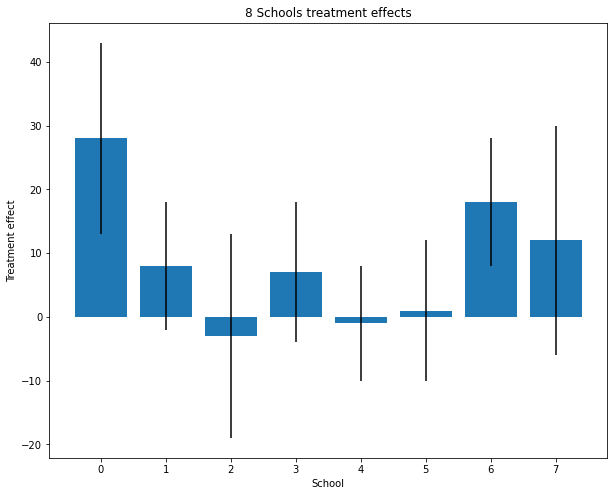

In [3]:
num_schools = 8  # number of schools
treatment_effects = jnp.array(
    [28, 8, -3, 7, -1, 1, 18, 12], dtype=jnp.float32)  # treatment effects
treatment_stddevs = jnp.array(
    [15, 10, 16, 11, 9, 11, 10, 18], dtype=jnp.float32)  # treatment SE

fig, ax = plt.subplots()
plt.bar(range(num_schools), treatment_effects, yerr=treatment_stddevs)
plt.title("8 Schools treatment effects")
plt.xlabel("School")
plt.ylabel("Treatment effect")
fig.set_size_inches(10, 8)
plt.show()

In [4]:
params = dict(
    mu=jnp.zeros(1),
    logtau=jnp.zeros(1),
    theta_prime=jnp.zeros(8),
)

data = dict(
    treatment_effect=treatment_effects,
    treatment_std=treatment_stddevs,
)

In [5]:
@jax.jit
def ln_posterior(params):
    target = 0.
    target += stats.norm.logpdf(params['mu'], 0., 10.)
    target += stats.norm.logpdf(params['logtau'], 5., 1.)
    target += stats.norm.logpdf(params['theta_prime']).sum()
    theta_i = params['mu'] + jnp.exp(params['logtau']) * params['theta_prime']
    target += stats.norm.logpdf(data['treatment_effect'], loc=theta_i, scale=data['treatment_std']).sum()
    return target.sum()

In [6]:
samples, momentum = hmc.sample(ln_posterior, params, n_chains=10, n_samples=1000, n_warmup=3000, step_size=0.2, leapfrog_steps=5)

100%|█████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:05<00:00, 793.71it/s]


In [7]:
school_effect_samples = samples['mu'] + jnp.exp(samples['logtau']) * samples['theta_prime']

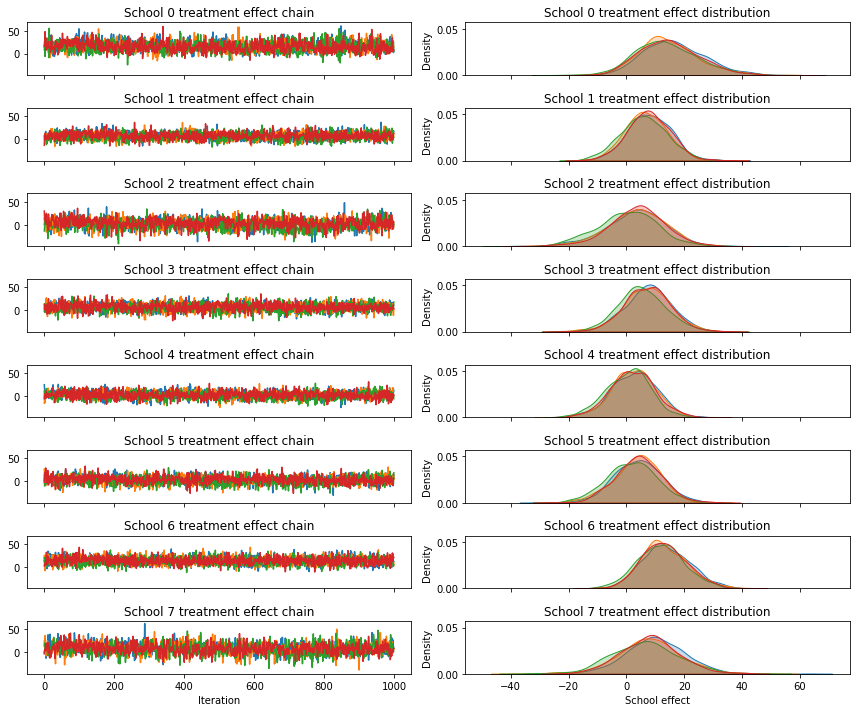

In [8]:
fig, axes = plt.subplots(8, 2, sharex='col', sharey='col')
fig.set_size_inches(12, 10)
for i in range(num_schools):
    for j in range(4):
      axes[i][0].plot(school_effect_samples[j,i])
      axes[i][0].title.set_text("School {} treatment effect chain".format(i))
      sns.kdeplot(school_effect_samples[j,i], ax=axes[i][1], shade=True)
      axes[i][1].title.set_text("School {} treatment effect distribution".format(i))
axes[num_schools - 1][0].set_xlabel("Iteration")
axes[num_schools - 1][1].set_xlabel("School effect")
fig.tight_layout()
plt.show()

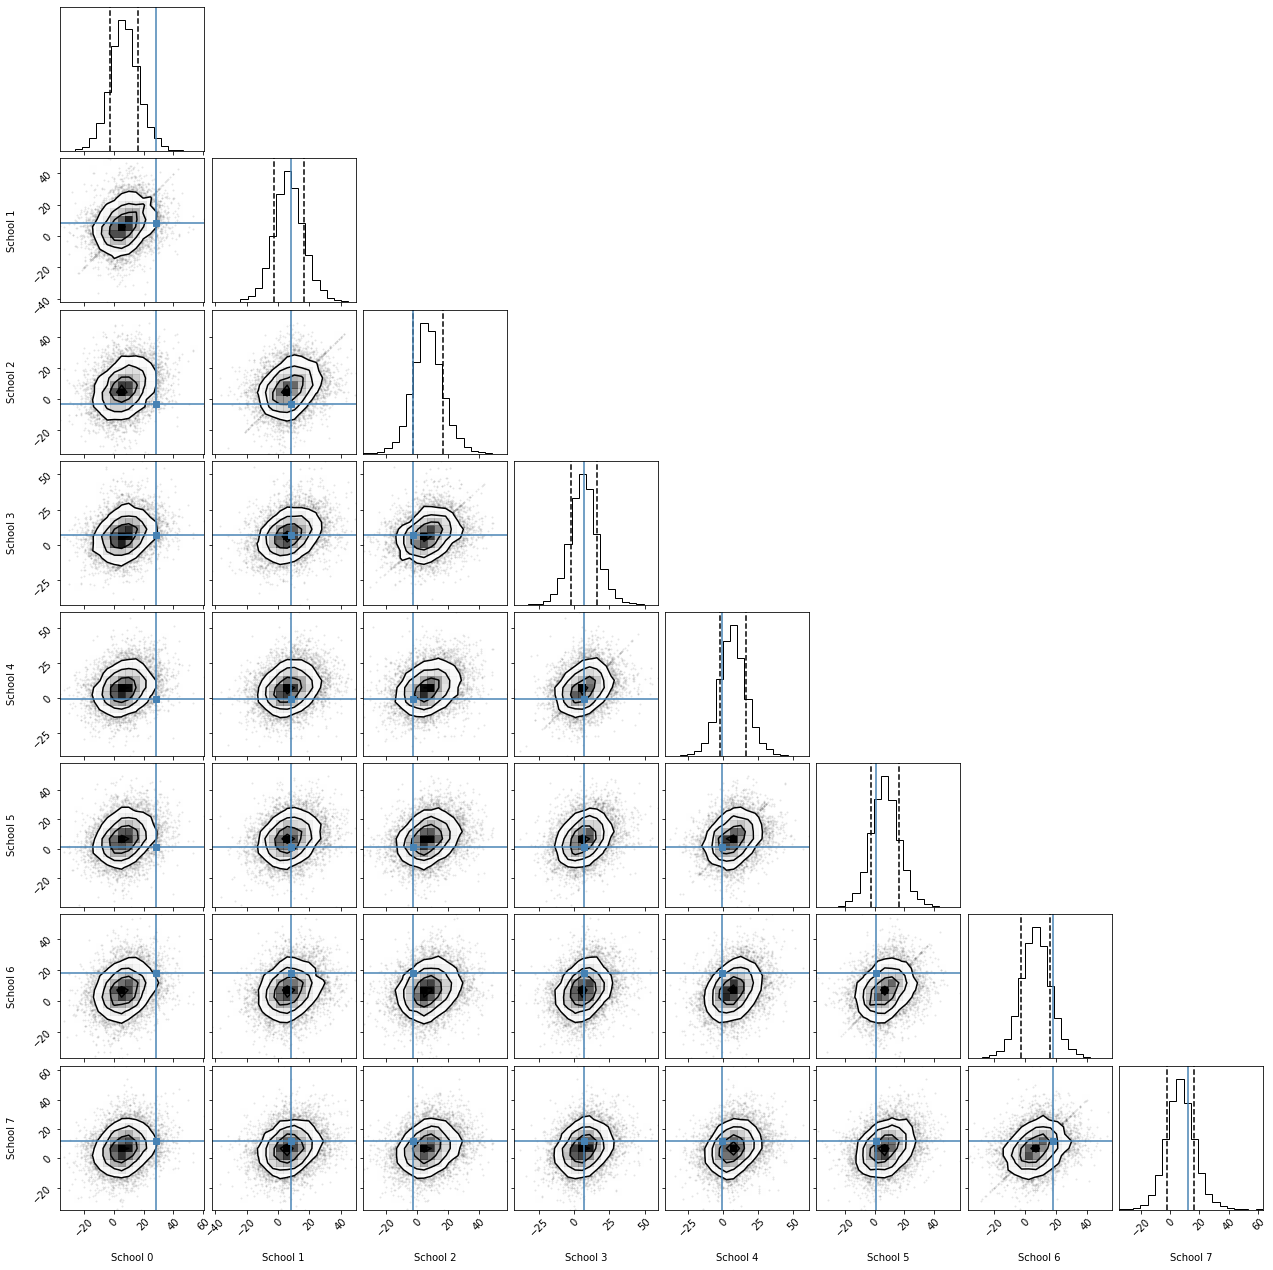

In [26]:
corner.corner(
    np.array(school_effect_samples).reshape(-1, 8),
    truths=treatment_effects,
    quantiles=[0.16, 0.84],
    labels=[f'School {i}' for i in range(8)]
);